In [2]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import pandas as pd
import time
import scipy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['figure.figsize'] = (8,8)
from sklearn import preprocessing

sns.set_style('white')
pd.set_option('display.max_columns', 35)

## READING IN DATA

In [9]:
print "Starting to read in data..."
t1 = time.time()
requests = pd.read_csv('311__Service_Requests.csv', parse_dates=True)
t2 = time.time()
print "Read in data in %.2f seconds." % (t2 - t1)


Starting to read in data...


//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read in data in 6.41 seconds.


In [10]:
# processing on the data types
print "Starting to process data types..."
t1 = time.time()
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    requests[col] = pd.to_datetime(requests[col], infer_datetime_format=True)
t2= time.time()
print "Dates processed in %.2f seconds." % (t2-t1)

Starting to process data types...
Dates processed in 570.76 seconds.


We first select all data from 2015, filter it down to all cases that were closed and originated from either constituent calls or the Citizens Connect App. The data altogether are standardized so that response time, longitude, and latitude each have zero mean and unit variance. We then separate the data sets to constituent calls and app origins. Each set is randomly shuffled and sampled to produce a smaller dataset. 

In [14]:
begin = pd.to_datetime('January 1, 2015 12:01AM')
end = pd.to_datetime('December 31, 2015 11:59PM')

closed_requests = requests[requests['CASE_STATUS'] == 'Closed']
closed_requests = closed_requests[(closed_requests['Source']=='Constituent Call') | (closed_requests['Source']=='Citizens Connect App')]

in_range= closed_requests[closed_requests['OPEN_DT'] > begin]
in_range = in_range[in_range['OPEN_DT'] < end]

times = (in_range['CLOSED_DT'] - in_range['OPEN_DT']).astype('timedelta64[m]')

print "Now standardizing data"
print "The mean response time is %.2f minutes with standard deviation %.2f minutes" % (np.mean(times), 
                                                                                       np.std(times))
print "The mean latitude is %.3f with standard deviation %.3f" % (np.mean(in_range['LATITUDE']), 
                                                                  np.std(in_range['LATITUDE']))
print "The mean longitude is %.3f with standard deviation %.3f" % (np.mean(in_range['LONGITUDE']), 
                                                                   np.std(in_range['LONGITUDE']))

times_scaled = preprocessing.scale(times)
latitude_scaled = preprocessing.scale(in_range['LATITUDE'])
longitude_scaled = preprocessing.scale(in_range['LONGITUDE'])


times_scaled_call = times_scaled[np.where(in_range['Source']=='Constituent Call')]
lat_scaled_call = latitude_scaled[np.where(in_range['Source']=='Constituent Call')]
long_scaled_call = longitude_scaled[np.where(in_range['Source']=='Constituent Call')]

times_scaled_app = times_scaled[np.where(in_range['Source']=='Citizens Connect App')]
lat_scaled_app = latitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]
long_scaled_app = longitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]

appdata = np.stack((times_scaled_app, long_scaled_app, lat_scaled_app), axis = 1)
calldata = np.stack((times_scaled_call,long_scaled_call, lat_scaled_call), axis = 1)

#randomizing the order of the data in order to downsample
np.random.shuffle(appdata)
appdata = appdata[::4]
print appdata.shape #checking size of array
np.random.shuffle(calldata)
calldata = calldata[::10]
print calldata.shape #checking size of array

#save downsampled data into npy format

np.save("appdataforgibbs", appdata)
np.save("calldataforgibbs",calldata)


Now standardizing data
The mean response time is 19020.74 minutes with standard deviation 41847.69 minutes
The mean latitude is 42.326 with standard deviation 0.034
The mean longitude is -71.083 with standard deviation 0.035
(9241, 3)
(10211, 3)


## Plotting Constituent Call and Citizens Connect data

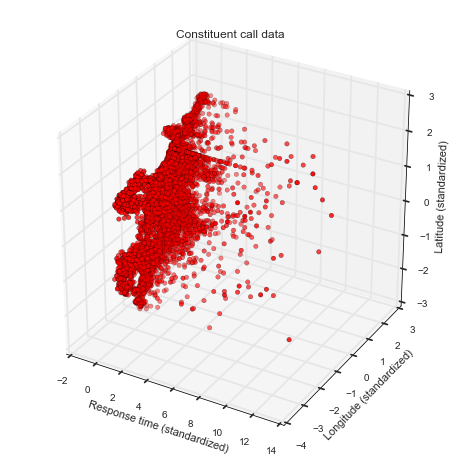

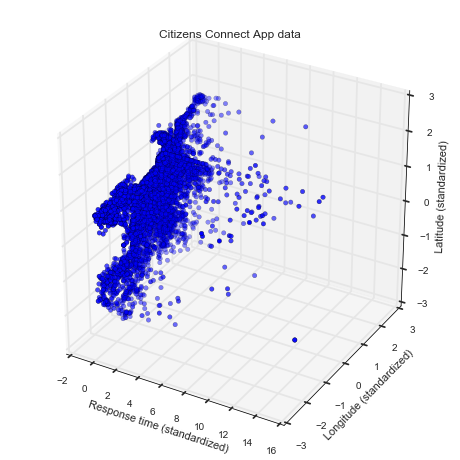

In [47]:

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(calldata[:,0], calldata[:,1], calldata[:,2], c = 'red')
ax.set_xlabel('Response time (standardized)')
ax.set_ylabel('Longitude (standardized)')
ax.set_zlabel('Latitude (standardized)')
ax.set_title('Constituent call data')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(appdata[:,0], appdata[:,1], appdata[:,2], c = 'blue')
ax.set_xlabel('Response time (standardized)')
ax.set_ylabel('Longitude (standardized)')
ax.set_zlabel('Latitude (standardized)')
ax.set_title('Citizens Connect App data')
plt.show()

## Gibbs Sampler

From the methods section of the written report:

The conditional distributions for the version of the Gaussian mixture model we used come from Gelman et al. and Jones et al. (full reference in the report bibliography). 
For the Gibbs sampler, each iteration requires the following steps: 

1. Each datapoint's indicator variable $Z_n$ is drawn from a multinomial distribution with the event probabilities given by 
$$
p(z_{nk} = 1| x_n, \mu, \Sigma, \pi)  \propto \pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k)
$$

2. The mixture coefficients are drawn from the conditional distribution 
$$
p(\pi|\mathbf{Z}) = \mathrm{Dir}(\{\alpha_{0,k}+ N_k\} )
$$
where $N_k$ is the number of observations assigned to each cluster. 

3. The component means are drawn from the conditional distribution 
$$
p(\mu_k | \Sigma_k, \mathbf{Z}, \mathbf{X}) = \mathcal{N}(\mu_k | m_k, V_k)
$$
where 
$$
V_k^{-1} = V_0^{-1} + N_k\Sigma_k^{-1}
$$
and 
$$
 m_k = V_k(\Sigma_k^{-1}N_k\overline{x}_k + V_0^{-1}m_0)
$$
 with $\overline{x}_k$  defined as the mean value of the observations assigned to component $k$. 
 
4. Finally, the component covariance matrices are drawn from the conditional distribution 
$$
 p(\Sigma_k | \mu_k, \mathbf{Z}, \mathbf{X}) = IW(\Sigma_k | S_k, \nu_0+N_k)
$$
 where 
$$
S_k = S_0 + \sum_{n=1}^N z_{nk}(x_n - \mu_k)(x_n - \mu_k)^\top
$$

In [18]:
from scipy.stats import invwishart, multivariate_normal, dirichlet

def update_Z(X, mu, Sigma, pi):
    """
    X: NxD matrix
    mu: Vector of k elements. Each element is a vector of D elements. 
    Sigma: Vector of k elements. Each element is a DxD covarianc ematrix
    pi: Vector of k scalars
    Returns Z, an NxK matrix made up of 1s and 0s (each row contains a single 1), describing the component assignments
    """
    
    N = len(X)
    K = len(mu)
    Z = np.zeros((N,K))

    probs_vector = np.zeros(K)

    for i in range(N):
        for j in range(K):

            probs_vector[j] = pi[j]*multivariate_normal.pdf(X[i], mean = mu[j], cov = Sigma[j])
        normalization = np.sum(probs_vector)
        probs_vector = probs_vector/normalization
        Z[i] = np.random.multinomial(1, probs_vector)     
    
    return Z


def update_N_k(Z):
    """
    Z: an NxK matrix made up of 1s and 0s (each row contains a single 1), describing the component assignments
    Returns a k-element vector describing number of elements in each cluster
    """
    N_k = np.sum(Z, axis = 0)
    
    return N_k

def update_pi(alpha_k, Z):
    """
    alpha_k: Vector of K scalars
    Z: an NxK matrix
    Returns pi: a vector of K scalars
    """
    N_k = np.sum(Z, axis = 0)
    pi = dirichlet.rvs(alpha_k+N_k)
    #specify that pi has to be in decreasing order
    while np.any(np.diff(pi)>0):
        pi = dirichlet.rvs(alpha_k+N_k)    
    return np.squeeze(pi)

def update_mean_x_k(Z, X, N_k):
    """
    Z: an NxK matrix made up of 1s and 0s (each row contains a single 1), describing the component assignments
    N_k: a k-element vector describing number of elements in each cluster
    mean_x_k: Matrix of dimension KxD, describing average value of observations belonging to cluster k
    """
    mean_x_k = np.zeros((len(N_k),len(X[0])))
    for i in range(len(mean_x_k)):
        for j in range(len(Z)):
            mean_x_k[i]+=Z[j][i]*X[j]
        mean_x_k[i] = mean_x_k[i]/N_k[i]

    
    return mean_x_k


def update_nu_k(nu_0, N_k):
    """
    N_k: a k-element vector describing number of elements in each cluster
    Returns nu_k: Returns a k-element vector describing the degrees of freedom of the inverse Wishart distribution
    """

    nu_k = nu_0+N_k

    return nu_k

def update_V_k(V_0, N_k, Sigma_k):
    """
    V_0: DxD matrix
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    Returns V_k: Vector of k elements (each element is a DxD covariance matrix)
    """
    V_k = np.zeros_like(Sigma_k)
    V_0_inv = np.linalg.inv(V_0)
    for i in range(len(V_k)):
        inv = V_0_inv+N_k[i]*np.linalg.inv(Sigma_k[i])
        V_k[i] = np.linalg.inv(inv)             
        
    return V_k
    
def update_m_k(V_k, Sigma_k, N_k, mean_x_k, V_0, m_0):
    """
    V_0: DxD matrix
    m_0: Vector of K elements, each element has D elements
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mean_x_k: DxK matrix describing average values of observations in each cluster
    Returns m_k: Vector of k elements, each element has a vector with D elements
    """
    V_0_inv = np.linalg.inv(V_0)
    m_k = np.zeros((len(N_k), len(m_0)))
    for i in range(len(m_k)):
        Sig_inv = np.linalg.inv(Sigma_k[i])

        m_k[i] = np.dot(V_k[i],(np.dot(Sig_inv,N_k[i]*mean_x_k[i])+np.dot(V_0_inv,m_0)))
    return m_k

def update_mu_k(m_k, V_k):
    """
    m_k: Vector of k elements, each element has a vector with D elements
    V_k: Vector of k elements, each element is a DxD covariance matrix
    Returns mu_k: Vector of k elements, each element has a vector with D elements
    """
    mu_k = np.zeros_like(m_k)

    for i in range(len(mu_k)):
        mu_k[i] = multivariate_normal.rvs(mean = m_k[i], cov = V_k[i])

    return mu_k

def update_S_k(Z, X, mu_k, S_0):
    """
    S_0: DxD matrix
    Returns S_k: array of k matrices (DxD) (Scale matrices for inverse wishart distribution)
    """
    S_k = np.zeros((len(mu_k), S_0.shape[0], S_0.shape[1]))
    for j in range(len(mu_k)):
        S_k[j]=np.copy(S_0)
        for i in range(len(Z)):
            S_k[j]+=Z[i][j]*np.outer((X[i]-mu_k[j]),(X[i]-mu_k[j]))
    return S_k

def update_Sigma_k(S_k, nu_k):
    """
    S_k: array of k matrices (DxD) (Scale matrices for inverse wishart distribution)
    Covariance matrices for the k clusters
    Returns: Covariance matrices for the k clusters
    """
    Sigma_k = np.zeros_like(S_k)
    for i in range(len(nu_k)):
        Sigma_k[i] = invwishart.rvs(nu_k[i], S_k[i])
    return Sigma_k

def gibbs_gmm(K, X, pi, mu, Sigma, nu_0, S_0, V_0, m_0, alpha_0):
    """
    Gibbs sampler
    K: number of components
    X: observations
    nu_0: dof for inverse Wishart distribution
    S_0: scale matrix for inverse Wishart distribution
    m_0: Mean of normal-inverse-Wishart distribution
    V_0: Covariance matrix of normal-inverse-Wishart distribution
    alpha_0: parameter for Dirichlet distribution
    mu: Vector of k elements. Each element is a vector of D elements. 
    Sigma: Vector of k elements. Each element is a DxD covarianc ematrix
    pi: Vector of k scalars
    """
    numsamples = 500
    start = time.time()
    Z_samples = np.zeros((numsamples, X.shape[0], pi.shape[0]))
    mu_samples = np.zeros((numsamples, mu.shape[0], mu.shape[1]))
    pi_samples = np.zeros((numsamples, K))
    Sigma_samples = np.zeros((numsamples, K, Sigma.shape[1], Sigma.shape[2]))
    nu_samples = np.zeros((numsamples, K))
    V_samples = np.zeros((numsamples, K, V_0.shape[0],V_0.shape[1]))
    m_samples = np.zeros((numsamples, K, m_0.shape[0]))
    S_samples = np.zeros_like(Sigma_samples)

    Z_samples[0] = update_Z(X, mu, Sigma, pi)
    N_k = update_N_k(Z_samples[0])
    pi_samples[0] = pi
    mean_x_k = update_mean_x_k(Z_samples[0], X, N_k)
    mu_samples[0] = mu
    Sigma_samples[0] = Sigma
    nu_samples[0] = update_nu_k(nu_0, N_k)
    V_samples[0] = update_V_k(V_0, N_k, Sigma_samples[0])
    m_samples[0] = update_m_k(V_samples[0], Sigma_samples[0], N_k, mean_x_k, V_0, m_0)
    S_samples[0] = update_S_k(Z_samples[0], X, mu_samples[0], S_0)

    for i in range(1,numsamples):
    
        Z_samples[i]= update_Z(X, mu_samples[i-1], Sigma_samples[i-1], pi_samples[i-1])
        N_k = update_N_k(Z_samples[i])
        if i%50==0:
            print i, time.time()-start
        pi_samples[i] = update_pi(alpha_0, Z_samples[i])
        mean_x_k = update_mean_x_k(Z_samples[i], X, N_k)
        mu_samples[i] = update_mu_k(m_samples[i-1], V_samples[i-1])
        Sigma_samples[i] = update_Sigma_k(S_samples[i-1], nu_samples[i-1])
        nu_samples[i] = update_nu_k(nu_0, N_k)
        V_samples[i]= update_V_k(V_0, N_k, Sigma_samples[i])
        m_samples[i] = update_m_k(V_samples[i], Sigma_samples[i], N_k, mean_x_k, V_0, m_0)
        S_samples[i] = update_S_k(Z_samples[i], X, mu_samples[i], S_0)

    return Z_samples, pi_samples, mu_samples, Sigma_samples, nu_samples, V_samples, m_samples, S_samples




## Sampling the posterior for call data

We initialize with the MAP parameter estimates for $\pi$, $\Sigma$, and $\mu$ from expectation maximization. $\nu_0$  =3 is set to be equal to the number of components, $S_0$ and $V_0$ are set to the identity matrices, and $\alpha_0$ and $m_0$ are set as vectors of ones such that the priors are weakly informative or non-informative, since we do not have much prior knowledge of how the clustering of request data should actually look. Given the large number of datapoints, these choices of values are expected to be less influential compared to what may occur with a smaller dataset (from the conditionals above, we see that $S_k$, $m_k$, and $V_k$ are strongly influenced by $N_k$, which in turn depends on the total number of datapoints. 

In [19]:
#call data fitting
K = 3 #number of components

#initializing with MAP results

pi = np.array([ 0.85561417, 0.13795177, 0.00643406])

#note that variables are in order: response time, longitude, latitude
Sigma = np.array([[[ 0.109255, 0.00936383, -0.00547017], 
                   [0.00936383, 1.12566872, 0.55098458], 
                   [-0.00547017, 0.55098458, 1.22771629]], 
                 [[ 1.92483963, 0.06452807, 0.0097768 ], 
                  [ 0.06452807,  1.28456653,  0.29894916],
                  [ 0.0097768,   0.29894916,  1.28388214]],
                 [[ 10.56069314, 0.4418922, 0.16616875], 
                  [0.4418922, 8.54962789,0.88448615],
                  [0.16616875, 0.88448615, 8.52842064]]])

mu = np.array([[ -2.85596910e-01,  -8.06180353e-02,  -2.30132447e-01], 
               [  1.44914839e+00,   5.81729345e-03,  -1.00870066e-01],
               [  7.00437911e+00,  -1.35817042e-01,  -1.67447475e-01]])
nu_0 = 3
S_0 = np.eye(3)
V_0 =  np.eye(3)
m_0 = np.array([1., 1., 1.])  
alpha_0 = np.array([1., 1., 1.])



Z_samples_c3, pi_samples_c3, mu_samples_c3, Sigma_samples_c3, nu_samples_c3, V_samples_c3, m_samples_c3, S_samples_c3= gibbs_gmm(K, 
                                                                                                         calldata, 
                                                                                                         pi,  
                                                                                                         mu, 
                                                                                                         Sigma, 
                                                                                                         nu_0, 
                                                                                                         S_0, 
                                                                                                         V_0, 
                                                                                                         m_0, 
                                                                                                         alpha_0)

50 161.544987917
100 320.633579016
150 477.142791986
200 636.278964043
250 796.517100096
300 952.516191959
350 1301.68565893
400 1741.04057407
450 1901.80416894


In [35]:
#save results of sample as backup
np.savez("calldatasamples.npz", Z = Z_samples_c3, pi = pi_samples_c3 , 
         mu = mu_samples_c3, Sigma  = Sigma_samples_c3, nu = nu_samples_c3,   
          V = V_samples_c3,  m =  m_samples_c3, S = S_samples_c3)

## Sampling posterior for app data

In [145]:
#app data fitting
K = 3

#initializing with MAP results

pi = np.array([0.83150555, 0.16061821, 0.00787624])

#note that variables are in order: response time, longitude, latitude
Sigma = np.array([[[ 0.1088711, -0.00862437, -0.00486507],
                   [-0.00862437, 0.96755996, 0.32477091],
                   [-0.00486507, 0.32477091, 0.79889581]], 
                  [[1.43729609, 0.16179275, 0.05837291],
                   [0.16179275, 1.36653982, 0.26216304],
                   [0.05837291, 0.26216304,1.07216398]],
                  [[11.86861284, 0.47086945, 0.20433425],
                   [0.47086945, 7.49374592, 0.58237359],
                   [0.20433425, 0.58237359, 7.50062468]]])

mu = np.array([[-0.32005411, 0.10147857, 0.23575437],
               [1.28475424, -0.04635469, 0.23087891],
               [7.34751927, -0.08100497,  0.11962156]])
nu_0 = 3
S_0 = np.eye(3)
V_0 =  np.eye(3)
m_0 = np.array([1., 1., 1.])  
alpha_0 = np.array([1., 1., 1.])



Z_samples_a3, pi_samples_a3, mu_samples_a3, Sigma_samples_a3, nu_samples_a3, V_samples_a3, m_samples_a3, S_samples_a3= gibbs_gmm(K, 
                                                                                                         appdata, 
                                                                                                         pi,  
                                                                                                         mu, 
                                                                                                         Sigma, 
                                                                                                         nu_0, 
                                                                                                         S_0, 
                                                                                                         V_0, 
                                                                                                         m_0, 
                                                                                                         alpha_0)

50 152.704195976
100 305.987414837
150 462.948587894
200 619.873004913
250 773.433478832
300 925.615272045
350 1066.33237982
400 1207.73044395
450 1351.31167603


In [146]:
#save results of sample as backup
np.savez("appdatasamples.npz", Z = Z_samples_a3, pi = pi_samples_a3 , 
         mu = mu_samples_a3, Sigma  = Sigma_samples_a3, nu = nu_samples_a3,   
          V = V_samples_a3,  m =  m_samples_a3, S = S_samples_a3)

## Posterior analysis

In [528]:
def get_mu_posterior(mu_samples, K, burnin):
    mu_avg = np.zeros_like(mu_samples[0])
    mu_std = np.zeros_like(mu_samples[0])
    for i in range(K):
        mu_avg[i] = np.mean(mu_samples[burnin:,i], axis = 0)
        mu_std[i] = np.std(mu_samples[burnin:,i], axis = 0)
    return mu_avg, mu_std

def get_pi_posterior(pi_samples, burnin):
    return np.mean(pi_samples[burnin:],axis = 0), np.std(pi_samples[burnin:], axis = 0)

def get_Sigma_posterior(Sigma_samples, burnin):
    return np.mean(Sigma_samples[burnin:],axis = 0), np.std(Sigma_samples[burnin:], axis = 0)

colors = ('#0096b2', '#63ffc4', '#ff7500')
def plot_mu_trace(mu_samples, K, title):
    f, ax = plt.subplots(3,3,figsize = (16,8), sharex = True)
    f.suptitle(title)
    for i in range(K):
        for j in range(mu_samples.shape[2]):
            ax[j,i].plot(mu_samples[:,i, j], color = colors[i])
    ax[0,0].set_ylabel("Response time (standardized)")
    ax[1,0].set_ylabel('Long. (normalized)')
    ax[2,0].set_ylabel("Lat. (normalized)")
    ax[0,2].set_xlabel('Iteration number')
    ax[0,0].annotate('Cluster 1', xycoords = 'axes fraction', xy = (0.75, 0.75))
    ax[0,1].annotate('Cluster 2', xycoords = 'axes fraction', xy = (0.75, 0.75))
    ax[0,2].annotate('Cluster 3', xycoords = 'axes fraction', xy = (0.75, 0.75))
                
    plt.show()
    
def plot_pi_trace(pi_samples, K, title):
    plt.figure(figsize = (6,6))
    for i in range(K):
        plt.plot(pi_samples[:,i], color=colors[i], label = "Cluster %d"  % (i+1,))
    plt.title(title)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of observations')
    plt.show()
    
def print_point_est(mu_samples, pi_samples, Sigma_samples,K, burnin):
    mu_avg, mu_std = get_mu_posterior(mu_samples, K, burnin)
    pi_avg, pi_std = get_pi_posterior(pi_samples, burnin)
    Sigma_avg, Sigma_std = get_Sigma_posterior(Sigma_samples, burnin)
    print "The variables are in order of response time, longitude, and latitude (standardized)"
    print "The posterior means for the cluster centers are:"
    for i in range(K):
        print
        print "Cluster %d" % (i+1,)
        print
        print pd.DataFrame(data = mu_avg[i], 
                       index = ('Response time', "Long.", "Lat."), 
                       columns  = ("Cluster center mean",))
        print
        print "with corresponding uncertainties"
        print
        print pd.DataFrame(data = mu_std[i], 
                       index = ('Response time', "Long.", "Lat."), 
                       columns  = ("Cluster center uncertainty",))
        
    print
    print "The posterior mean cluster fractions are"
    print pd.DataFrame(data = pi_avg, 
                       index = ('Cluster 1', "Cluster 2", "Cluster 3"), 
                       columns  = ("Mean fraction",))
    print "with corresponding uncertainties"
    print pd.DataFrame(data = pi_std, 
                       index = ('Cluster 1', "Cluster 2", "Cluster 3"), 
                       columns  = ("Fraction uncertainty",))
    print 
    print "The posterior cluster covariance matrices are"
    for i in range(K):
        print
        print "Cluster %d" % (i+1,)
        print 
        print pd.DataFrame(data = Sigma_avg[i], 
                           index = ('Response', 'Long.', 'Lat.'),
                          columns = ('Response', 'Long.', 'Lat.'))
        print 
        print "with corresponding uncertainties"
        print pd.DataFrame(data = Sigma_std[i],
                          index = ('Response', 'Long.', 'Lat.'),
                          columns = ('Response', 'Long.', 'Lat.'))
        
def plot_cluster_assignments(Z_samples, burnin, data, title):
    labelmode, count = scipy.stats.mstats.mode(Z_samples[burnin:])
    labelmode = np.squeeze(labelmode)
    cluster1 = data[np.where(labelmode[:,0]==1)]
    cluster2 = data[np.where(labelmode[:,1]==1)]
    cluster3 = data[np.where(labelmode[:,2]==1)]
    size = 8
    fig = plt.figure(figsize = (size,size))
    ax = fig.add_subplot(111,projection = '3d')
    ax.scatter(cluster1[:,0], cluster1[:,1], cluster1[:,2], c = colors[0])
    ax.scatter(cluster2[:,0], cluster2[:,1], cluster2[:,2], c = colors[1])
    ax.scatter(cluster3[:,0], cluster3[:,1], cluster3[:,2], c = colors[2])
    ax.set_xlabel('Response time (standardized)')
    ax.set_ylabel('Longitude (standardized)')
    ax.set_zlabel('Latitude (standardized)')
    ax.set_xlim(xmin = -2, xmax = 14)
    ax.set_ylim(ymin = -4, ymax  = 3)
    ax.set_zlim(zmin = -4, zmax = 3)
    ax.set_title(title,size = 12)
    plt.show()
    
def plot_cluster_assignments_2d(Z_samples, burnin, data, title):
    """Plots projection of clustered data points onto longitude-latitude plane"""
    labelmode, count = scipy.stats.mstats.mode(Z_samples[burnin:])
    labelmode = np.squeeze(labelmode)
    cluster1 = data[np.where(labelmode[:,0]==1)]
    cluster2 = data[np.where(labelmode[:,1]==1)]
    cluster3 = data[np.where(labelmode[:,2]==1)]
    size = 8
    fig = plt.figure(figsize = (size,size))
    plt.scatter(cluster1[:,1], cluster1[:,2], c = colors[0], alpha = 0.4)
    plt.scatter(cluster2[:,1], cluster2[:,2], c = colors[1], alpha = 0.6)
    plt.scatter(cluster3[:,1], cluster3[:,2], c = colors[2],alpha = 0.7)
    plt.setp(ax.get_xticklabels(), fontsize = size)
    plt.setp(ax.get_yticklabels(), fontsize = size)
    plt.xlabel('Longitude (standardized)', size = 12, labelpad = 5)
    plt.ylabel('Latitude (standardized)', size = 12, labelpad =5)
    plt.ylim(ymin = -3.5, ymax = 2.5)
    plt.xlim(xmin = -3, xmax = 3)
    plt.title(title, size = 12)
    plt.show()
    
def posterior_predictive(pi_samples, mu_samples, Sigma_samples, burnin, title):
    pi_posterior = pi_samples[burnin:]
    mu_posterior = mu_samples[burnin:]
    Sigma_posterior = Sigma_samples[burnin:]
    K = 3
    samplesize = 10000
    labels = np.zeros((samplesize, K))
    predicted_vals = np.zeros((samplesize, 3))
    #draw from posteriors
    draw = np.random.randint(low = 0, high = len(pi_posterior)+1)
    pi_draw = pi_posterior[draw]
    mu_draw = mu_posterior[draw]
    Sigma_draw = Sigma_posterior[draw]
    #now sample from likelihood
    #first, determine which cluster the randomly drawn point belongs to 
    for i in range(samplesize):
        r = np.random.uniform()
        if r < pi_draw[0]:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[0], cov = Sigma_draw[0])
            labels[i] = np.array([1,0,0])
        elif r > 1-pi_draw[2]:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[2], cov = Sigma_draw[2])
            labels[i] = np.array([0,0,1])
        else:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[1], cov = Sigma_draw[1])
            labels[i] = np.array([0,1,0])
    size = 8       
    cluster1 = predicted_vals[np.where(labels[:,0]==1)]
    cluster2 = predicted_vals[np.where(labels[:,1]==1)]
    cluster3 = predicted_vals[np.where(labels[:,2]==1)]
    fig = plt.figure(figsize = (size,size))
    plt.plot(cluster3[:,1], cluster3[:,2])
    
    ax = fig.add_subplot(111,projection = '3d')
    ax.scatter(cluster1[:,0], cluster1[:,1], cluster1[:,2], c = colors[0])
    ax.scatter(cluster2[:,0], cluster2[:,1], cluster2[:,2], c = colors[1])
    ax.scatter(cluster3[:,0], cluster3[:,1], cluster3[:,2], c = colors[2])
    plt.setp(ax.get_xticklabels(), fontsize = 12)
    plt.setp(ax.get_yticklabels(), fontsize = 12)
    plt.setp(ax.get_zticklabels(), fontsize = 12)
    ax.set_xlabel('Response time (standardized)', size = 12, labelpad = 5)
    ax.set_ylabel('Longitude (standardized)', size = 12, labelpad =5)
    ax.set_zlabel('Latitude (standardized)', size = 12, labelpad = 5)
    ax.set_xlim(xmin = -2, xmax = 14)
    ax.set_ylim(ymin = -4, ymax  = 3)
    ax.set_zlim(zmin = -4, zmax = 3)
    ax.set_title(title, size = 12)
    
    plt.show()
    
def posterior_predictive_projection(pi_samples, mu_samples, Sigma_samples, burnin, title):
    """Projects posterior predictive projection clusters onto longitude-latitude plane"""
    pi_posterior = pi_samples[burnin:]
    mu_posterior = mu_samples[burnin:]
    Sigma_posterior = Sigma_samples[burnin:]
    K = 3
    samplesize = 10000
    labels = np.zeros((samplesize, K))
    predicted_vals = np.zeros((samplesize, 3))
    #draw from posteriors
    draw = np.random.randint(low = 0, high = len(pi_posterior)+1)
    pi_draw = pi_posterior[draw]
    mu_draw = mu_posterior[draw]
    Sigma_draw = Sigma_posterior[draw]
    #now sample from likelihood
    #first, determine which cluster the randomly drawn point belongs to 
    for i in range(samplesize):
        r = np.random.uniform()
        if r < pi_draw[0]:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[0], cov = Sigma_draw[0])
            labels[i] = np.array([1,0,0])
        elif r > 1-pi_draw[2]:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[2], cov = Sigma_draw[2])
            labels[i] = np.array([0,0,1])
        else:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[1], cov = Sigma_draw[1])
            labels[i] = np.array([0,1,0])
    size = 8      
    cluster1 = predicted_vals[np.where(labels[:,0]==1)]
    cluster2 = predicted_vals[np.where(labels[:,1]==1)]
    cluster3 = predicted_vals[np.where(labels[:,2]==1)]
    fig = plt.figure(figsize = (size,size))
    plt.scatter(cluster1[:,1], cluster1[:,2], c = colors[0], alpha = 0.4)
    plt.scatter(cluster2[:,1], cluster2[:,2], c = colors[1], alpha = 0.6)
    plt.scatter(cluster3[:,1], cluster3[:,2], c = colors[2], alpha = 0.7)
    plt.setp(ax.get_xticklabels(), fontsize = 12)
    plt.setp(ax.get_yticklabels(), fontsize = 12)
    plt.xlabel('Longitude (standardized)', size = 12, labelpad = 5)
    plt.ylabel('Latitude (standardized)', size = 12, labelpad =5)
    plt.ylim(ymin = -3.5, ymax = 2.5)
    plt.xlim(xmin = -3, xmax = 3)
    plt.title(title, size = 12)
    
    plt.show()
    

def print_mu_est_realunits(mu_samples, K, burnin):
    """Converts mu samples from standardized units back to response time
    in days and longitude and latitude in decimal degrees"""
    response_mean = 13.2 #days
    response_std = 29.1
    long_mean = -71.083
    long_std = 0.035
    lat_mean = 42.326
    lat_std = 0.034
    mu_avg, mu_std = get_mu_posterior(mu_samples, K, burnin)
    mu_avg[:,0] = mu_avg[:,0]*response_std+response_mean
    mu_std[:,0] = mu_std[:,0]*response_std
    mu_avg[:,1] = mu_avg[:,1]*long_std+long_mean
    mu_std[:,1] = mu_std[:,1]*long_std
    mu_avg[:,2] = mu_avg[:,2]*lat_std+lat_mean
    mu_std[:,2] = mu_std[:,2]*lat_std
    print "The variables are in order of response time (days), longitude, and latitude (decimal degrees)"
    print "The posterior means for the cluster centers are:"
    for i in range(K):
        print
        print "Cluster %d" % (i+1,)
        print
        print pd.DataFrame(data = mu_avg[i], 
                       index = ('Response time', "Long.", "Lat."), 
                       columns  = ("Cluster center mean",))
        print
        print "with corresponding uncertainties"
        print
        print pd.DataFrame(data = mu_std[i], 
                       index = ('Response time', "Long.", "Lat."), 
                       columns  = ("Cluster center uncertainty",))
        
def plot_mu_hist(mu_samples, burnin, title = None):
    """plot posterior distributions of mu"""
    f, ax = plt.subplots(3,3,figsize = (16,8))
    f.suptitle(title)
    for i in range(K):
        for j in range(mu_samples.shape[2]):
            ax[j,i].hist(mu_samples[burnin:,i, j], color = colors[i], bins  = 15, normed = True)
    ax[0,0].set_ylabel("Response time (normalized)")
    ax[1,0].set_ylabel('Long. (normalized)')
    ax[2,0].set_ylabel("Lat. (normalized)")
    #ax[0,2].set_xlabel('Iteration number')
    ax[0,0].annotate('Cluster 1', xycoords = 'axes fraction', xy = (0.75, 0.75))
    ax[0,1].annotate('Cluster 2', xycoords = 'axes fraction', xy = (0.75, 0.75))
    ax[0,2].annotate('Cluster 3', xycoords = 'axes fraction', xy = (0.75, 0.75))
                
    plt.show()
    #plt.hist(samples[burnin:], bins = 15)
    #plt.show()
    
def plot_pi_hist(pi_samples, K, burnin, title):
    """Plot posterior distributions of pi"""
    plt.figure(figsize = (6,6))
    for i in range(K):
        plt.hist(pi_samples[burnin:,i], color=colors[i], label = "Cluster %d"  % (i+1,), bins = 15, normed = True)
    plt.title(title)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Fraction of observations')
    plt.show()




### Traces for call data 

We plot sample traces to assess convergence. Traces for $\mu$ and $\pi$ suggest convergence after $\sim$150 iterations. 

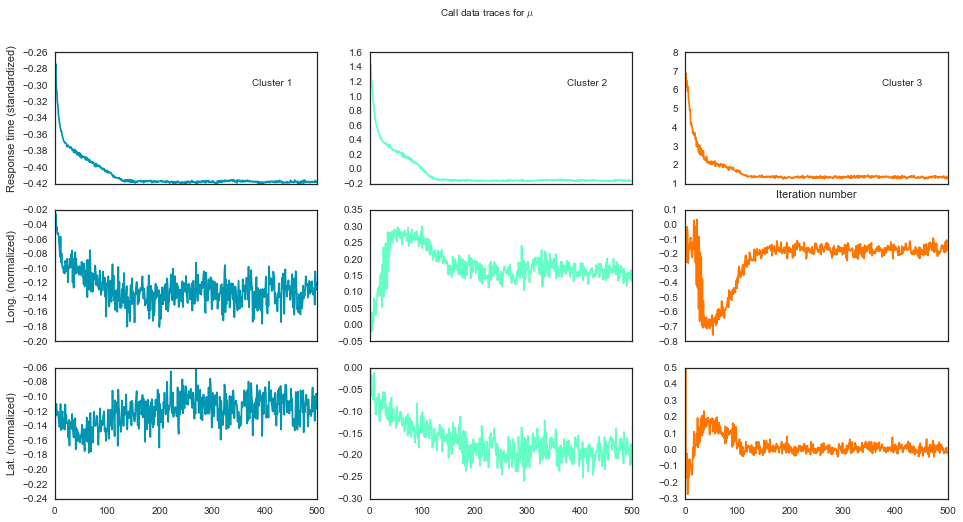

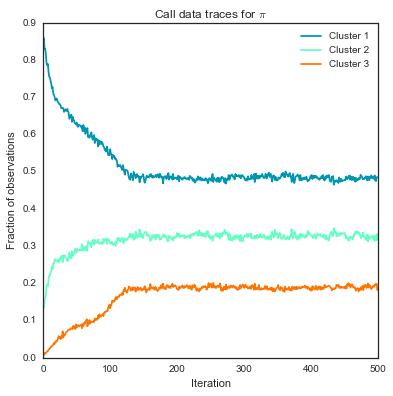

In [121]:
plot_mu_trace(mu_samples_c3, K, "Call data traces for $\mu$")
plot_pi_trace(pi_samples_c3, K, "Call data traces for $\pi$")


### Point estimates for call data

Below, we plot the histograms of the samples after burnin for the call data and print the posterior means and uncertainties for $\mu$, $\Sigma$, and $\pi$. 

The covariance matrices of the components indicate that within each component, response time does not correlate strongly with longitude and latitude. The differences between the component means are largely due to separation in response times rather than in geography. We see cluster separation into two with relatively short response times and one with much longer typical response times. The largest cluster has the shortest response times, while the smallest cluster has the longest response times. 

These results are similar to those generated from EM MLE parameter estimates (shown in another notebook), but differ from the EM MAP parameter estimates in that the cluster with lagging response times is larger in the Gibbs sampler results, so the mean of the component is also smaller (though still substantially slower than the other two components). 

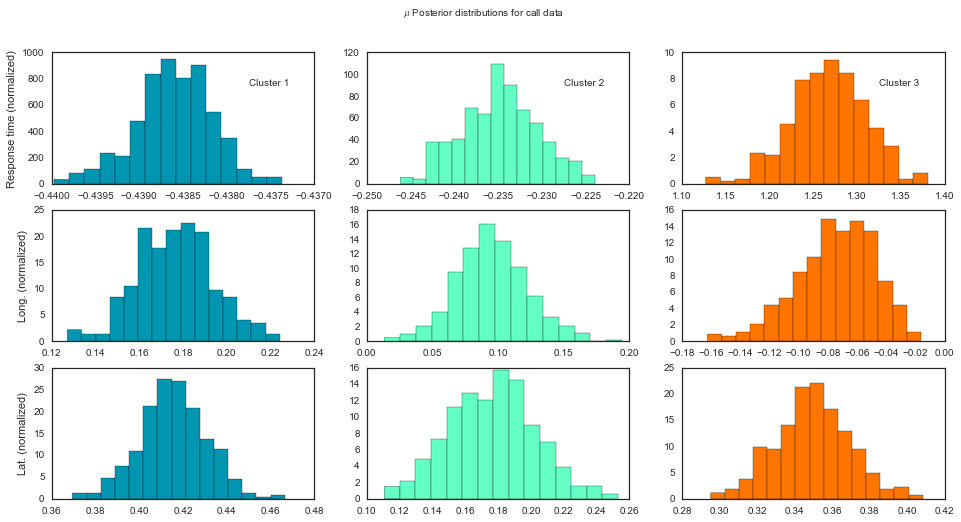

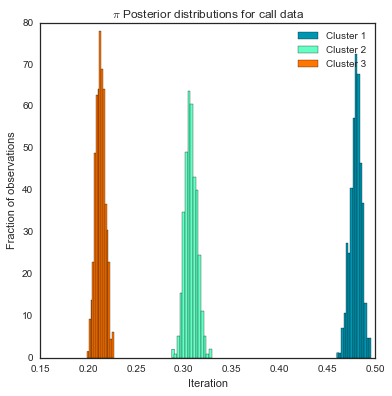

In [462]:
plot_mu_hist(mu_samples_a3,150,title = "$\mu$ Posterior distributions for call data")
plot_pi_hist(pi_samples_a3,3, 150,title = "$\pi$ Posterior distributions for call data")

In [120]:
print_point_est(mu_samples_c3, pi_samples_c3, Sigma_samples_c3, K, 150)

The variables are in order of response time, longitude, and latitude (standardized)
The posterior means for the cluster centers are:

Cluster 1

               Cluster center mean
Response time            -0.417602
Long.                    -0.133749
Lat.                     -0.113354

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.000962
Long.                            0.015891
Lat.                             0.017406

Cluster 2

               Cluster center mean
Response time            -0.156258
Long.                     0.165866
Lat.                     -0.187727

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.005972
Long.                            0.021567
Lat.                             0.024099

Cluster 3

               Cluster center mean
Response time             1.351716
Long.                    -0.172865
Lat.                      0.006499

with

In [527]:
print_mu_est_realunits(mu_samples_c3, 3, 150)

The variables are in order of response time (days), longitude, and latitude (decimal degrees)
The posterior means for the cluster centers are:

Cluster 1

               Cluster center mean
Response time             1.047784
Long.                   -71.087681
Lat.                     42.322146

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.027991
Long.                            0.000556
Lat.                             0.000592

Cluster 2

               Cluster center mean
Response time             8.652896
Long.                   -71.077195
Lat.                     42.319617

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.173799
Long.                            0.000755
Lat.                             0.000819

Cluster 3

               Cluster center mean
Response time            52.534937
Long.                   -71.089050
Lat.                     42.32

### Traces for app data

Traces for $\mu$ and $\pi$ suggest convergence after $\sim$150 iterations. 

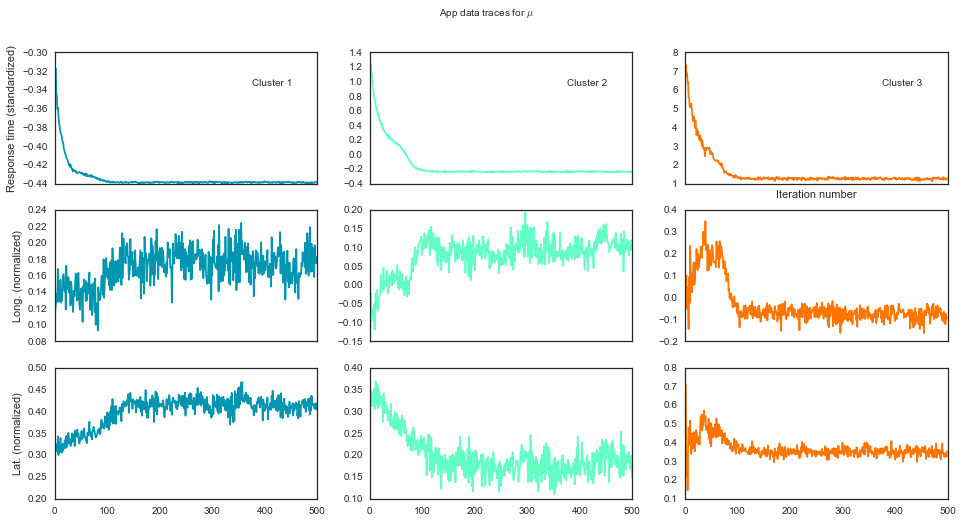

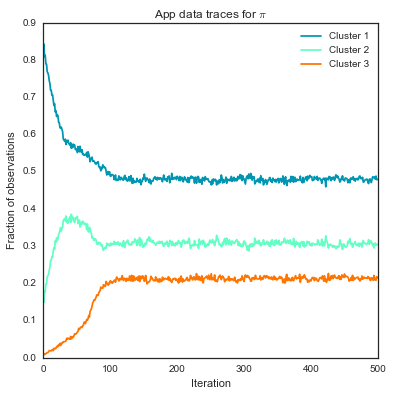

In [310]:
plot_mu_trace(mu_samples_a3, 3, "App data traces for $\mu$")
plot_pi_trace(pi_samples_a3, 3, "App data traces for $\pi$")

### Posterior means and uncertainties for app data

We plot sample posterior distributions for $\mu$ and $\pi$, and list the posterior means and uncertainties for $\mu$, $\Sigma$, and $\pi$. As with the call data, the covariance matrices of the components indicate that within each component, response time does not correlate strongly with longitude and latitude. The differences between the component means are largely due to separation in response times rather than in geography. As with the call data, we see cluster separation into two with relatively short response times and one with much longer typical response times. The largest cluster has the shortest response times, while the smallest cluster has the longest response times. 

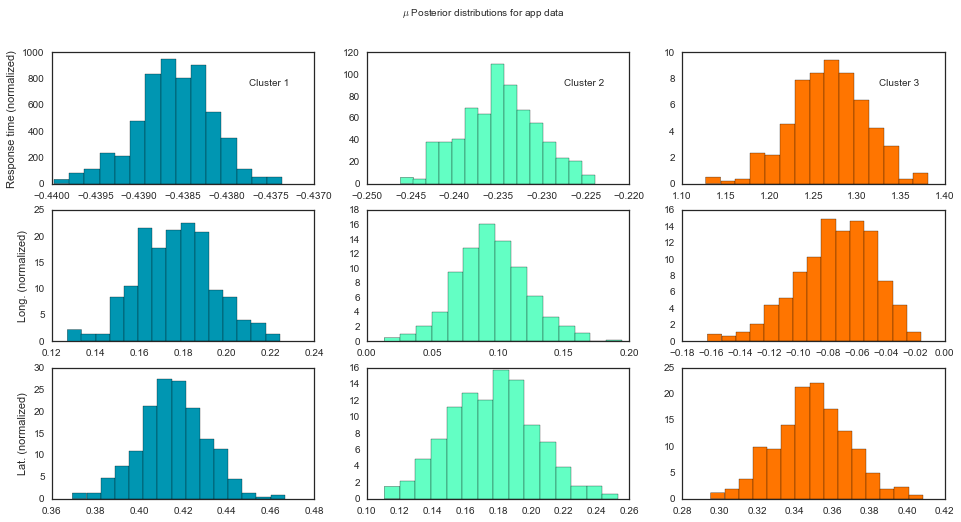

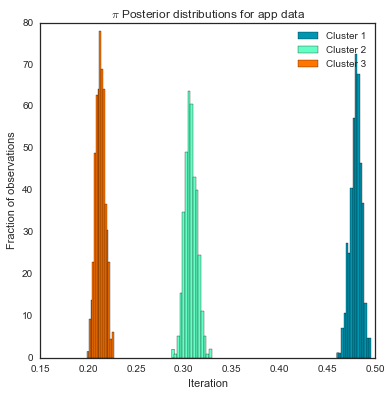

In [458]:
plot_mu_hist(mu_samples_a3,150,title = "$\mu$ Posterior distributions for app data")
plot_pi_hist(pi_samples_a3,3, 150,title = "$\pi$ Posterior distributions for app data")


In [148]:
print_point_est(mu_samples_a3, pi_samples_a3, Sigma_samples_a3, K, 150)

The variables are in order of response time, longitude, and latitude (standardized)
The posterior means for the cluster centers are:

Cluster 1

               Cluster center mean
Response time            -0.438603
Long.                     0.176566
Lat.                      0.415617

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.000442
Long.                            0.017472
Lat.                             0.015403

Cluster 2

               Cluster center mean
Response time            -0.234840
Long.                     0.095565
Lat.                      0.176607

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.004319
Long.                            0.027541
Lat.                             0.025978

Cluster 3

               Cluster center mean
Response time             1.267452
Long.                    -0.074500
Lat.                      0.349923

with

In [526]:
print_mu_est_realunits(mu_samples_a3, 3, 150)

The variables are in order of response time (days), longitude, and latitude (decimal degrees)
The posterior means for the cluster centers are:

Cluster 1

               Cluster center mean
Response time             0.436664
Long.                   -71.076820
Lat.                     42.340131

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.012866
Long.                            0.000612
Lat.                             0.000524

Cluster 2

               Cluster center mean
Response time             6.366144
Long.                   -71.079655
Lat.                     42.332005

with corresponding uncertainties

               Cluster center uncertainty
Response time                    0.125688
Long.                            0.000964
Lat.                             0.000883

Cluster 3

               Cluster center mean
Response time            50.082866
Long.                   -71.085607
Lat.                     42.33

### Cluster assignments based on posterior samples

Based on the mode of the labels identified in the posterior distribution, we plot the cluster assignments below for the call and app data. The call data request clusters are spread out more evenly across the city compared to the app data request clusters, which are more concentrated near Downtown/Backbay in the northeast. 

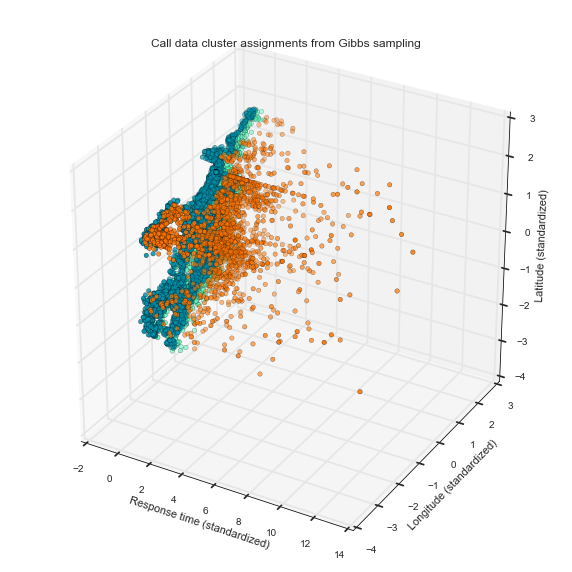

In [402]:
calldatasaved = np.load("calldataforgibbs.npy")
plot_cluster_assignments(Z_samples_c3, 150, calldatasaved, title = 'Call data cluster assignments from Gibbs sampling')

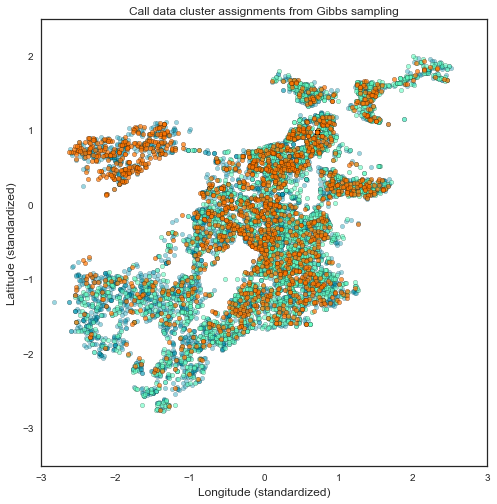

In [514]:
plot_cluster_assignments_2d(Z_samples_c3, 
                            150, 
                            calldatasaved, 
                            title = 'Call data cluster assignments from Gibbs sampling')

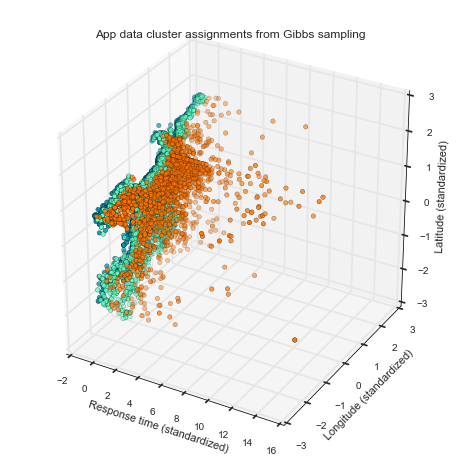

In [390]:
appdatasaved = np.load("appdataforgibbs.npy")
plot_cluster_assignments(Z_samples_a3, 150, appdatasaved, title = 'App data cluster assignments from Gibbs sampling')

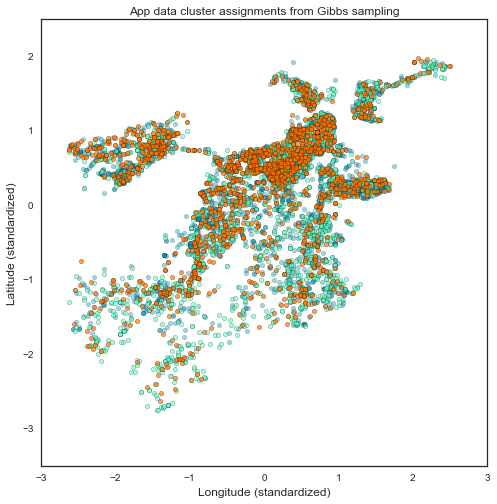

In [515]:

plot_cluster_assignments_2d(Z_samples_a3, 
                            150, 
                            appdatasaved, 
                            title = 'App data cluster assignments from Gibbs sampling')

### Posterior predictive distributions

To evaluate the quality of the fit, we also plotted the posterior predictive distributions for app and call data, and projected the clusters onto the longitude-latitude plane. The tight and diffuse parts of the data along the response time axis suggest the need for multiple components to fit, which is partly addressed by the fitting of multiple Gaussian components. The posterior predictive for app data shows that the Gaussian components are somewhat more compact and less elliptical than the call data, which is consistent with the app data being more concentrated in the Northeast of Boston. The highly elliptical shape of the call data clusters reflects more comprehensive coverage around Boston, which itself is highly elongated. However, the very longest response times observed in the data are not well-reproduced by the mixture model. Given the complex geography of Boston, modeling with Gaussians would be regarded as a first approximation. 

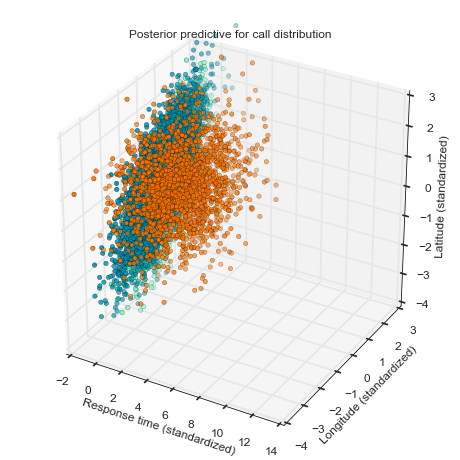

In [415]:
posterior_predictive(pi_samples_c3, mu_samples_c3, 
                     Sigma_samples_c3, 150,"Posterior predictive for call distribution")

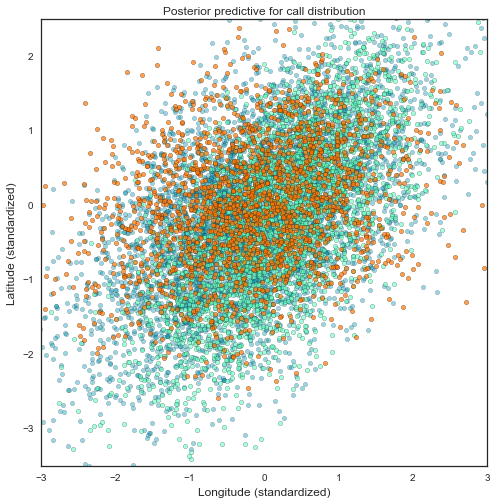

In [413]:
posterior_predictive_projection(pi_samples_c3, mu_samples_c3, 
                     Sigma_samples_c3, 150,"Posterior predictive for call distribution")

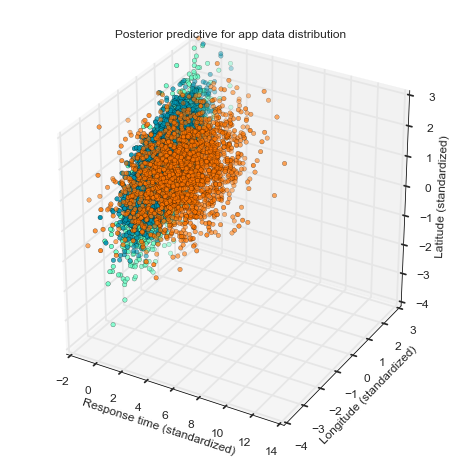

In [408]:
posterior_predictive(pi_samples_a3, mu_samples_a3, 
                     Sigma_samples_a3, 150,"Posterior predictive for app data distribution")

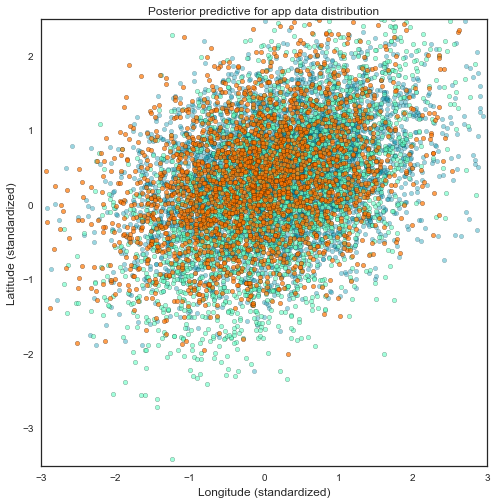

In [414]:
posterior_predictive_projection(pi_samples_a3, mu_samples_a3, 
                     Sigma_samples_a3, 150,"Posterior predictive for app data distribution")

## PyMC comparison

We also tested a PyMC implementation of a Gaussian mixture model on the app data. Since PyMC functions are in terms of the precision matrix rather than the covariance matrix, we use a Wishart prior for the precision matrix rather than an inverse-Wishart prior for the covariance matrix. (Just as the inverse-Wishart prior was useful for sampling from the space of positive-semidefinite matrices, the Wishart prior is useful for sampling valid precision matrices). The traceplots for certain variables were examined after 40,000 iterations, which seemed to indicate that convergence had not been achieved. PyMC does not appear to be efficient for this type of model. 

In [419]:
import pymc as pm
from pymc.distributions import mv_normal_like

In [506]:
#-------------   model parameters
K = 3
M = 3
alpha = np.array(np.ones(K))  #parameter for Dirichlet prior 
nu = K #degrees of freedom has to be greater than K - 1
W = np.eye(M) #scale matrix for the Wishart prior
beta = 1. #scaling relation between precision matrix of multivariate normal distribution for mu and scale matrix for Wishart prior
eta = np.array(np.ones(M) ) #mean for wishart-normal dist
data = appdatasaved

#-------------   priors
#mixture coefficient
PI = pm.Dirichlet('PI', theta=alpha)

#precision matrices
L = pm.Container([pm.Wishart("L_%d" % i, n = nu, Tau = W) for i in range(K)])
    
#means
center = pm.Container([pm.MvNormal("mu_%d" % i, mu=eta, tau=beta*L[i]) for i in range(K)])
      
#latent component membership
Z = pm.Categorical('Z', p=PI, size=N)
    
@pm.stochastic(observed = True)
def results(value = data, labels = Z, means = center, precision = L):
    logprob = 0
    for i in range(N):
        cluster = labels[i]
        logprob+=mv_normal_like(value[i], means[cluster], precision[cluster])
    return logprob

#-------------   sampling parameters
iters = 40000
burn = 20000
#-------------   pymc sampler
mc = pm.MCMC([PI, center, L, Z, results])
mc.sample(iter=iters, burn=burn, thin = 2)


 [-----------------100%-----------------] 40000 of 40000 complete in 651.4 sec

Plotting mu_0_0
Plotting mu_0_1
Plotting mu_0_2
Plotting mu_1_0
Plotting mu_1_1
Plotting mu_1_2
Plotting mu_2_0
Plotting mu_2_1
Plotting mu_2_2


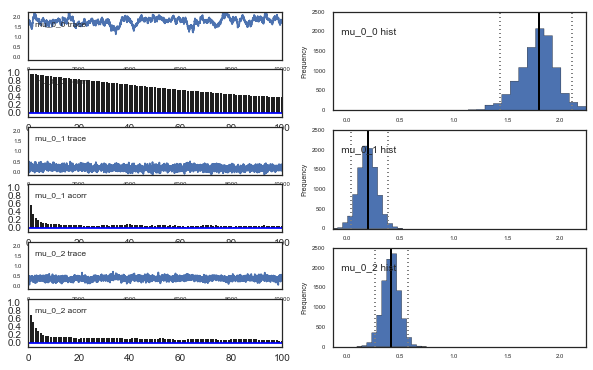

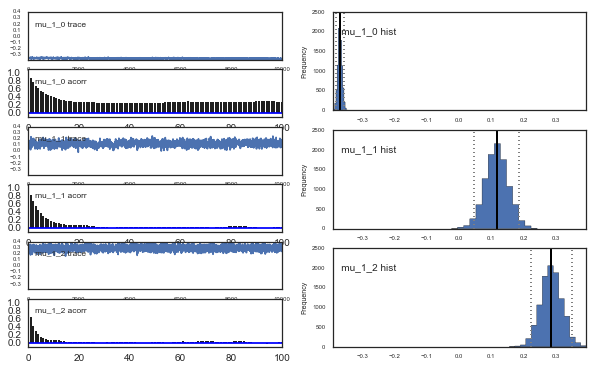

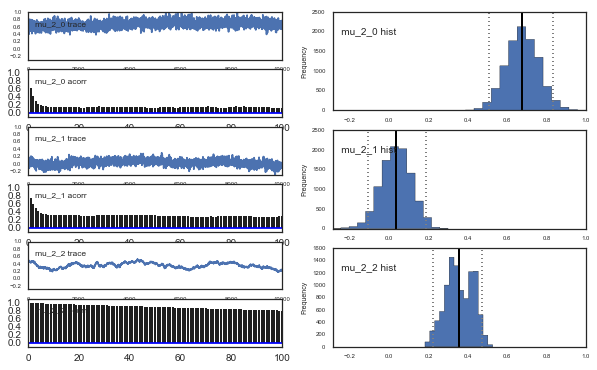

In [509]:
pm.Matplot.plot(center[0])
pm.Matplot.plot(center[1])
pm.Matplot.plot(center[2])


## A brief exploration of alternative analyses of response time data

Given that the Gaussian components we found were largely separated along the response time axis, it may be natural to examine response time distributions as a one-dimensional problem. As pointed out earlier in the posterior predictive analysis, the Gaussian mixture model does not capture the tendency for extremely outlying response times to be observed. When doing a 3-dimensional model of response time, longitude, and latitude of requests, a multivariate Gaussian model was applied because both the latitude and longitude data appeared to be approximable by Gaussians, although the response time data showed a heavier skew. With a one-dimensional analysis of response time, we can examine distributions that might reproduce the long tails. 

One reasonable one-dimensional distribution to try might be an exponential, since it peaks at small values and then decays rapidly. Below, we compare a model of an exponential distribution of app response times to the actual distribution of response times, using the posterior predictive distribution generated in PyMC. The prior for the mean, $\lambda$, is chosen to be the non-informative prior $-\log(\lambda)$, which ensures that $\lambda$ is positive and allows for extreme values, although those are disfavored. The histogram below indicates that an exponential model vastly underestimates the number of response times that are very short and overestimates the number of longer response times. 

Returning to the idea of the mixture model, one might also consider trying a mixture of exponentials, which could be interpreted as a group of requests that close rapidly and another group where responses are dragged out substantially. This idea is motivated in part by a discussion of extended hospital stays in http://support.sas.com/rnd/app/examples/stat/BayesMixtureExp/new_example/.  
The likelihood of this model would thus be 

$$ \mathcal{L} = \pi \mathrm{Exp}(-\lambda)+(1-\pi)\mathrm{Exp}(-(\lambda+\delta))$$

where $\pi$ is the probability of a request coming from the first component. The parameterization of the mean of the second exponential as $\lambda+\delta$ allows the two components to be distinguishable. 

We fit this model again to the app data with PyMC, using a non-informative Dirichlet prior for $\pi$ and the $-\log(\lambda)$ and $-\log(\delta)$ for $\lambda$ and $\delta$. This model puts 45 percent of the app requests in group where the mean time to close a request is 0.35 days, while the remainder are in a group where on average, it takes 23 days to close a request. The posterior predictive plotted below suggests that the mixture model better replicates the observed data compared to the exponential model, although some of the initial problems with the single exponential model remain (the number of requests with very short closing times is still underpredicted and the number with longer closing times are overpredicted, which would lead to poorer estimates for the proportion of the request population likely to have responses closed quickly. Using an exponential mixture, a partial pooling approach by neighborhood or department could be useful for developing predictions of response times, which could in turn be useful for allocating resources. 

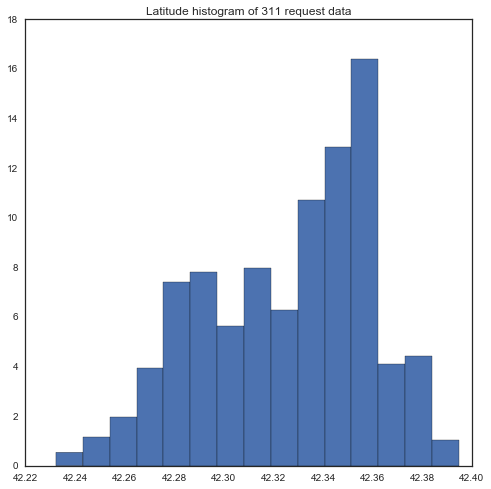

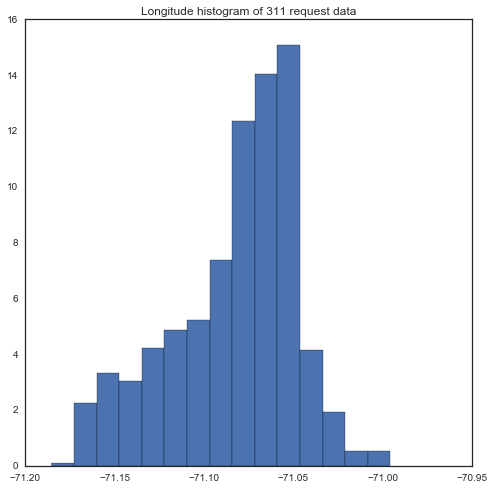

In [540]:
plt.hist(in_range['LATITUDE'], normed = True,bins = 15)
plt.title('Latitude histogram of 311 request data')
plt.show()
plt.hist(in_range['LONGITUDE'], normed = True,bins = 15)
plt.title('Longitude histogram of 311 request data')
plt.show()

In [543]:
times_app = times[in_range['Source']=='Citizens Connect App']/(24*60.) #conversion to days

In [547]:
#fitting a single exponential to data
@pm.stochastic(observed=False)
def lambda_param(value = 10):
    return -np.log(value)

response_times = pm.Exponential('response_times',beta = 1/lambda_param,value = times_app,observed = True)
response_model = pm.Model([lambda_param, response_times])

mcmc = pm.MCMC(response_model)
mcmc.sample(iter = 16000, thin = 2, burn = 8000)

 [-----------------100%-----------------] 16000 of 16000 complete in 27.5 sec


lambda_param:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	12.926           0.07             0.002          [ 12.79   13.058]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	12.79            12.877          12.925         12.976        13.058
	
Plotting lambda_param


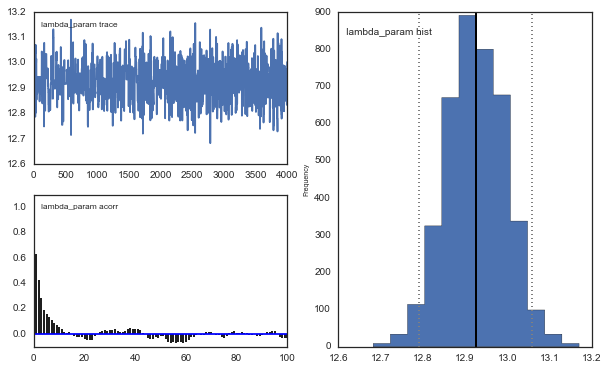

In [548]:
mcmc.summary()
pm.Matplot.plot(lambda_param)
plt.show()

In [550]:
#posterior predictive sampling
responsetimes = pm.Exponential('responsetimes', beta = 1/lambda_param)

expo_sim = pm.MCMC([responsetimes])
expo_sim.sample(iter=16000, burn = 8000, thin = 2)

 [-----------------100%-----------------] 16000 of 16000 complete in 0.3 sec

In [551]:
expo_sim_trace = expo_sim.trace('responsetimes')[:]

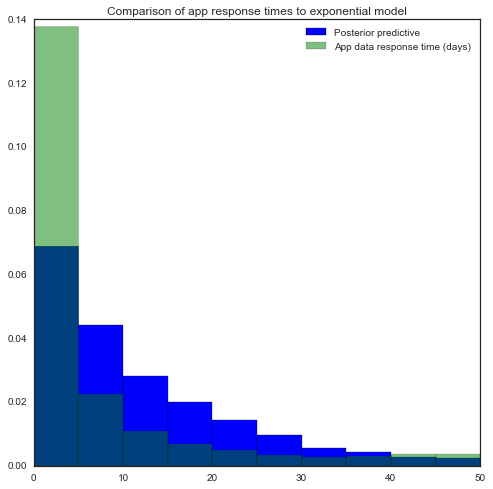

In [568]:
plt.hist(expo_sim_trace, normed = True, range = (0,50),color = 'blue', label = 'Posterior predictive')
plt.hist(times_app,normed = True,range = (0,50),alpha = 0.5,color = 'green', label = 'App data response time (days)')
plt.title('Comparison of app response times to exponential model')
plt.legend()
plt.show()

In [562]:
#exponential mixture model
from pymc.distributions import exponential_like
from scipy.stats import expon
@pm.stochastic(observed=False)
def lambda_param(value = 10):
    return -np.log(value)

@pm.stochastic(observed=False)
def lambda_param_offset(value = 10):
    return -np.log(value)

pi = pm.Dirichlet('PI', theta = np.array([1,1]))

@pm.stochastic(observed = True)
def response_times(value = times_app, 
                   observed = True, 
                   p = pi, 
                   lambda1 = lambda_param, 
                   offset = lambda_param_offset):
    return np.sum(np.log(p*expon.pdf(value, scale = lambda1)+(1-p)*expon.pdf(value, scale = (offset+lambda1))))

mcmc = pm.MCMC([lambda_param, lambda_param_offset, pi, response_times])
mcmc.sample(iter = 20000, burn = 10000, thin = 2)

 [-----------------100%-----------------] 20001 of 20000 complete in 213.8 sec


lambda_param:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.357            0.006            0.0              [ 0.347  0.368]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.346            0.352           0.357          0.36          0.368
	

lambda_param_offset:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	23.025           0.178            0.006          [ 22.689  23.387]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	22.689           22.903          23.019         23.142        23.39
	

PI:
 
	Mean             SD               MC Error        95% HPD interval
	---

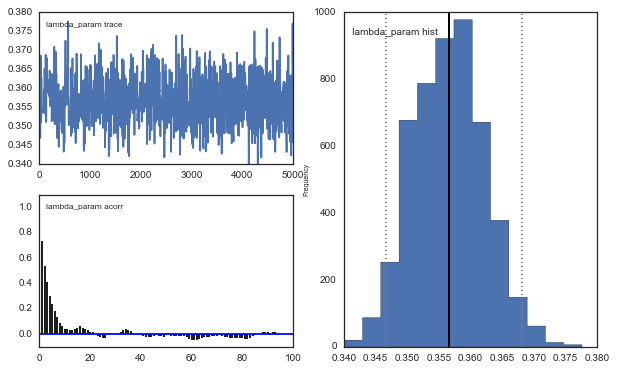

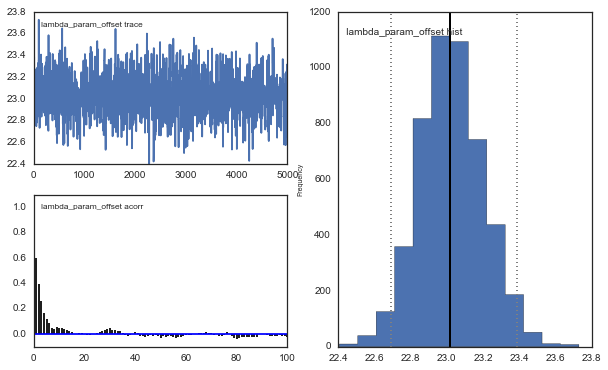

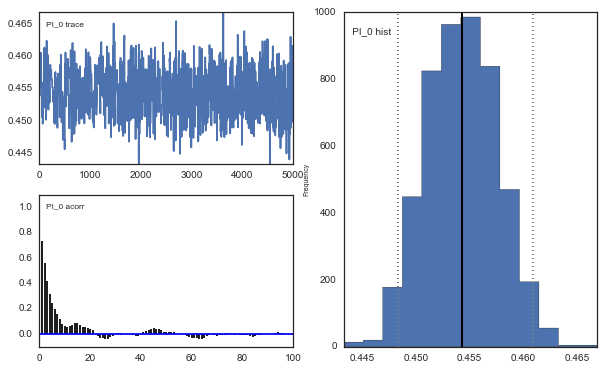

In [563]:
mcmc.summary()
pm.Matplot.plot(lambda_param)
pm.Matplot.plot(lambda_param_offset)
pm.Matplot.plot(pi)
plt.show()

In [564]:
#posterior predictive distribution sampling
@pm.stochastic(observed = False)
def responsetimes(value = 10, p = pi, lambda1 = lambda_param, offset = lambda_param_offset):
    return np.sum(np.log(p*expon.pdf(value, scale = lambda1)+(1-p)*expon.pdf(value, scale = (offset+lambda1))))

mixedexpo_sim = pm.MCMC([responsetimes])
mixedexpo_sim.sample(iter=16000, burn = 8000, thin = 2)

 [-----------------100%-----------------] 16000 of 16000 complete in 2.5 sec

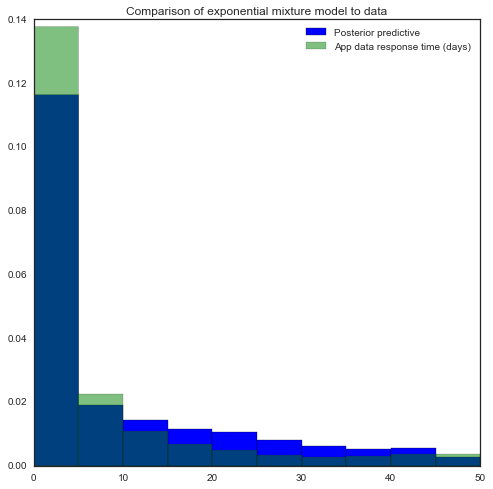

In [569]:
mixedexpo_sim_trace = mixedexpo_sim.trace('responsetimes')[:]
plt.hist(mixedexpo_sim_trace, normed = True, range = (0,50),color = 'blue', label = 'Posterior predictive')
plt.hist(times_app,normed = True,range = (0,50),alpha = 0.5,color = 'green', label = 'App data response time (days)')
plt.title('Comparison of exponential mixture model to data')
plt.legend()
plt.show()